In [1]:
%matplotlib inline

import os
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
import harmonypy
from cnmf import cNMF
import seaborn as sns
import yaml
from scipy.stats import pearsonr
from IPython.display import Image
from matplotlib.pyplot import rc_context

sys.path.append('../../../Code/')
from utils import read_dataset_log, match_columns

# B-cell

In [2]:
paths ={'Original': '../../../Data/PerDataset/HaoEtAl/haoetal_pbmc_multimodal.merged.ADTfixed.h5ad',
 'RNA_Varnorm_Harmony': '../../../Data/PerDataset/HaoEtAl/haoetal_pbmc_multimodal.merged.ADTfixed.B.20231227.RNA.VarNorm.HVG.HarmonyGeneCorrect.h5ad',
 'RNA_HVG_List': '../../../Data/PerDataset/HaoEtAl/haoetal_pbmc_multimodal.merged.ADTfixed.B.20231227.RNA.HVGlist.tsv',
 'Metadata': '../../../Data/PerDataset/HaoEtAl/haoetal_pbmc_multimodal.merged.ADTfixed.B.20231227.metadata.tsv',
 'Raw_Filt_For_cNMF': '../../../Data/PerDataset/HaoEtAl/haoetal_pbmc_multimodal.merged.ADTfixed.B.20231227.FiltForcNMF.h5ad',
 'ADT_MI_Rank': '../../../Data/PerDataset/HaoEtAl/haoetal_pbmc_multimodal.merged.ADTfixed.B.20231227.ADT.TP10K.VarNorm.leidenRNA_MI.tsv',
 'ADT_Varnom_Harmony': '../../../Data/PerDataset/HaoEtAl/haoetal_pbmc_multimodal.merged.ADTfixed.B.20231227.ADT.VarNorm.HVG.HarmonyGeneCorrect.h5ad',
 'RNA_and_ADT_TP10K': '../../../Data/PerDataset/HaoEtAl/haoetal_pbmc_multimodal.merged.ADTfixed.B.20231227.RNA_and_ADT.TP10K.h5ad',
 'RNA_and_ADT_HVG_List': '../../../Data/PerDataset/HaoEtAl/haoetal_pbmc_multimodal.merged.ADTfixed.B.20231227.RNA_and_ADT.HVGlist.tsv',
 'RNA_and_ADT_Varnorm_Harmony_WNN': '../../../Data/PerDataset/HaoEtAl/haoetal_pbmc_multimodal.merged.ADTfixed.B.20231227.RNA_and_ADT.VarNorm.HVG.HarmonyGeneCorrect.h5mu',
 'RNA_and_ADT_Varnorm_Harmony': '../../../Data/PerDataset/HaoEtAl/haoetal_pbmc_multimodal.merged.ADTfixed.B.20231227.RNA_and_ADT.VarNorm.HVG.HarmonyGeneCorrect.h5ad',
 'WNN_UMAP': '../../../Data/PerDataset/HaoEtAl/haoetal_pbmc_multimodal.merged.ADTfixed.B.20231227.RNA_and_ADT.TP10K.VarNorm.HVG.HarmonyGeneCorrect.WNN.UMAP.tsv'}

## Run cNMF

In [3]:
cnmfdir = '../../../Data/PerDataset/HaoEtAl'
name = 'HIVVaccine.Bcell'

In [7]:
cnmf_count_fn = paths['RNA_Varnorm_Harmony']
cnmf_tpm_fn = paths['RNA_and_ADT_TP10K']
hvg_fn = paths['RNA_HVG_List']

jname = name
cnmfout = os.path.join(cnmfdir, name, 'log')

Ks = np.arange(10, 50)
n_iter = 20
num_per_node = 10

In [8]:
cnmf_obj = cNMF(output_dir=cnmfdir, name=name)

In [9]:
cnmf_obj.prepare(counts_fn=cnmf_count_fn, components=Ks,
                 n_iter=n_iter, tpm_fn=cnmf_tpm_fn, genes_file=hvg_fn, init='random')

Only considering the two last: ['.HarmonyGeneCorrect', '.h5ad'].
Only considering the two last: ['.HarmonyGeneCorrect', '.h5ad'].
Only considering the two last: ['.tpm', '.h5ad'].
Only considering the two last: ['.tpm', '.h5ad'].


/PHShome/dk718/miniforge3/envs/cnmf_env2v2/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Only considering the two last: ['.norm_counts', '.h5ad'].
Only considering the two last: ['.norm_counts', '.h5ad'].


In [10]:
total_workers = int((len(Ks)*n_iter) / num_per_node)
total_workers

80

In [11]:
if not os.path.exists(cnmfout): os.mkdir(cnmfout)

basecmd = "export OMP_NUM_THREADS=6; cnmf factorize --name {name} --output-dir {outdir} --total-workers {tw} --worker-index {i}"
q = 'short'
other = '-R "rusage[mem=2000]" -R "select[hname!=cn001]" -R "select[hname!=cn002]" -R "select[hname!=cn003]" -R "select[hname!=cn004]" -R "select[hname!=cn005]" -R "select[hname!=cn007]"'

for i in range(total_workers):
    cmd = basecmd.format(name=name, outdir=cnmfdir, i=i, tw=total_workers)
    e = os.path.join(cnmfout, '{j}.{i}.err.txt').format(i=i, j=jname)
    o = os.path.join(cnmfout, '{j}.{i}.out.txt').format(i=i, j=jname)
    bsub_cmd = 'bsub -q {q} -J {j} -o {o} -e {e} {other} "{cmd}"'.format(q=q, j=jname, e=e, o=o, other=other, cmd=cmd)
    print(bsub_cmd)
    !{bsub_cmd}

bsub -q short -J HIVVaccine.Bcell -o ../../../Data/PerDataset/HaoEtAl/HIVVaccine.Bcell/log/HIVVaccine.Bcell.0.out.txt -e ../../../Data/PerDataset/HaoEtAl/HIVVaccine.Bcell/log/HIVVaccine.Bcell.0.err.txt -R "rusage[mem=2000]" -R "select[hname!=cn001]" -R "select[hname!=cn002]" -R "select[hname!=cn003]" -R "select[hname!=cn004]" -R "select[hname!=cn005]" -R "select[hname!=cn007]" "export OMP_NUM_THREADS=6; cnmf factorize --name HIVVaccine.Bcell --output-dir ../../../Data/PerDataset/HaoEtAl --total-workers 80 --worker-index 0"
Job <107235> is submitted to queue <short>.
bsub -q short -J HIVVaccine.Bcell -o ../../../Data/PerDataset/HaoEtAl/HIVVaccine.Bcell/log/HIVVaccine.Bcell.1.out.txt -e ../../../Data/PerDataset/HaoEtAl/HIVVaccine.Bcell/log/HIVVaccine.Bcell.1.err.txt -R "rusage[mem=2000]" -R "select[hname!=cn001]" -R "select[hname!=cn002]" -R "select[hname!=cn003]" -R "select[hname!=cn004]" -R "select[hname!=cn005]" -R "select[hname!=cn007]" "export OMP_NUM_THREADS=6; cnmf factorize --nam

In [12]:
! bjobs | wc -l

No unfinished job found
0


In [13]:
total_workers = int((len(Ks)*n_iter))
total_workers

800

In [14]:
import os
def worker_filter(iterable, worker_index, total_workers):
    return (p for i,p in enumerate(iterable) if (i-worker_index)%total_workers==0)

def load_df_from_npz(filename):
    with np.load(filename, allow_pickle=True) as f:
        obj = pd.DataFrame(**f)
    return obj

missing = []
run_params = load_df_from_npz(cnmf_obj.paths['nmf_replicate_parameters'])
for worker_i in range(total_workers):
    jobs_for_this_worker = worker_filter(range(len(run_params)), worker_i, total_workers)
    for idx in jobs_for_this_worker:
        p = run_params.iloc[idx, :]
        outfn = cnmf_obj.paths['iter_spectra'] % (p['n_components'], p['iter'])
        if not os.path.exists(outfn):
            print(worker_i, outfn)
            missing.append(worker_i)

In [15]:
len(missing)

0

In [16]:
cnmf_obj.combine(skip_missing_files=True)

Combining factorizations for k=10.
Combining factorizations for k=11.
Combining factorizations for k=12.
Combining factorizations for k=13.
Combining factorizations for k=14.
Combining factorizations for k=15.
Combining factorizations for k=16.
Combining factorizations for k=17.
Combining factorizations for k=18.
Combining factorizations for k=19.
Combining factorizations for k=20.
Combining factorizations for k=21.
Combining factorizations for k=22.
Combining factorizations for k=23.
Combining factorizations for k=24.
Combining factorizations for k=25.
Combining factorizations for k=26.
Combining factorizations for k=27.
Combining factorizations for k=28.
Combining factorizations for k=29.
Combining factorizations for k=30.
Combining factorizations for k=31.
Combining factorizations for k=32.
Combining factorizations for k=33.
Combining factorizations for k=34.
Combining factorizations for k=35.
Combining factorizations for k=36.
Combining factorizations for k=37.
Combining factorizat

Only considering the two last: ['.norm_counts', '.h5ad'].
Only considering the two last: ['.norm_counts', '.h5ad'].
CPU times: user 11min 58s, sys: 25min 12s, total: 37min 10s
Wall time: 1min 43s


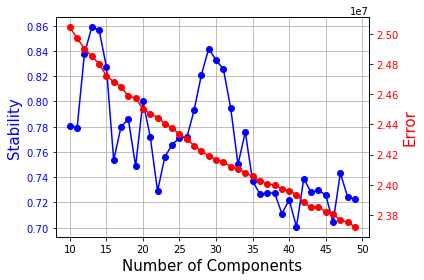

In [17]:
%%time
cnmf_obj.k_selection_plot()

In [22]:
kthresh = {29:0.15, 30:0.15, 31:0.15, 34:0.3}


Only considering the two last: ['.norm_counts', '.h5ad'].
Only considering the two last: ['.norm_counts', '.h5ad'].
Only considering the two last: ['.tpm', '.h5ad'].
Only considering the two last: ['.tpm', '.h5ad'].


/PHShome/dk718/miniforge3/envs/cnmf_env2v2/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Only considering the two last: ['.norm_counts', '.h5ad'].
Only considering the two last: ['.norm_counts', '.h5ad'].
Only considering the two last: ['.tpm', '.h5ad'].
Only considering the two last: ['.tpm', '.h5ad'].


/PHShome/dk718/miniforge3/envs/cnmf_env2v2/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Only considering the two last: ['.norm_counts', '.h5ad'].
Only considering the two last: ['.norm_counts', '.h5ad'].
Only considering the two last: ['.tpm', '.h5ad'].
Only considering the two last: ['.tpm', '.h5ad'].


/PHShome/dk718/miniforge3/envs/cnmf_env2v2/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Only considering the two last: ['.norm_counts', '.h5ad'].
Only considering the two last: ['.norm_counts', '.h5ad'].
Only considering the two last: ['.tpm', '.h5ad'].
Only considering the two last: ['.tpm', '.h5ad'].


/PHShome/dk718/miniforge3/envs/cnmf_env2v2/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


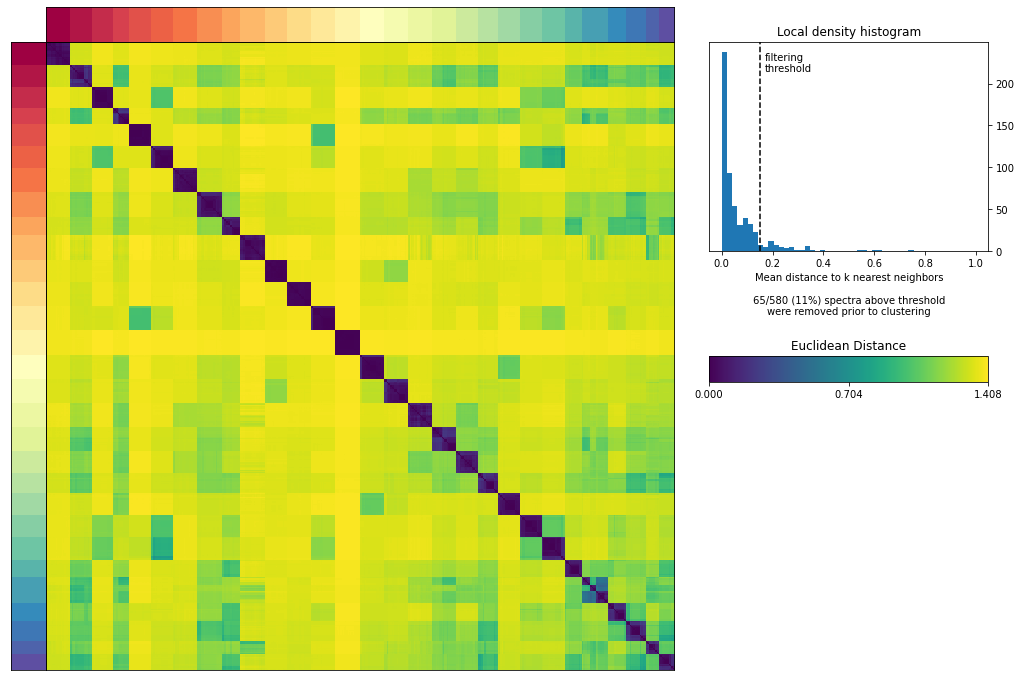

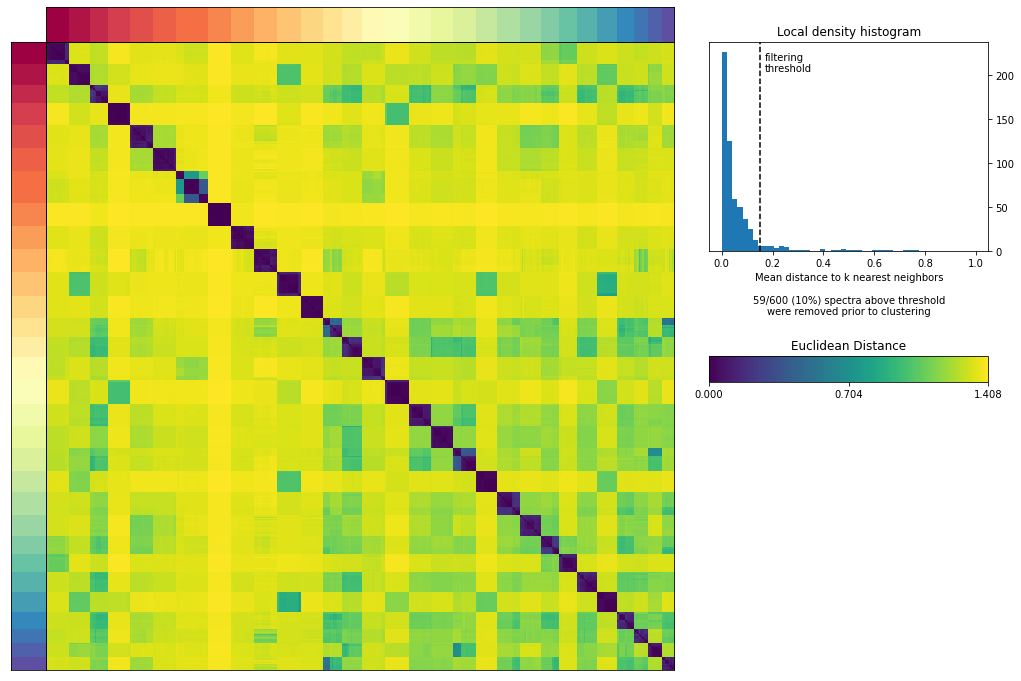

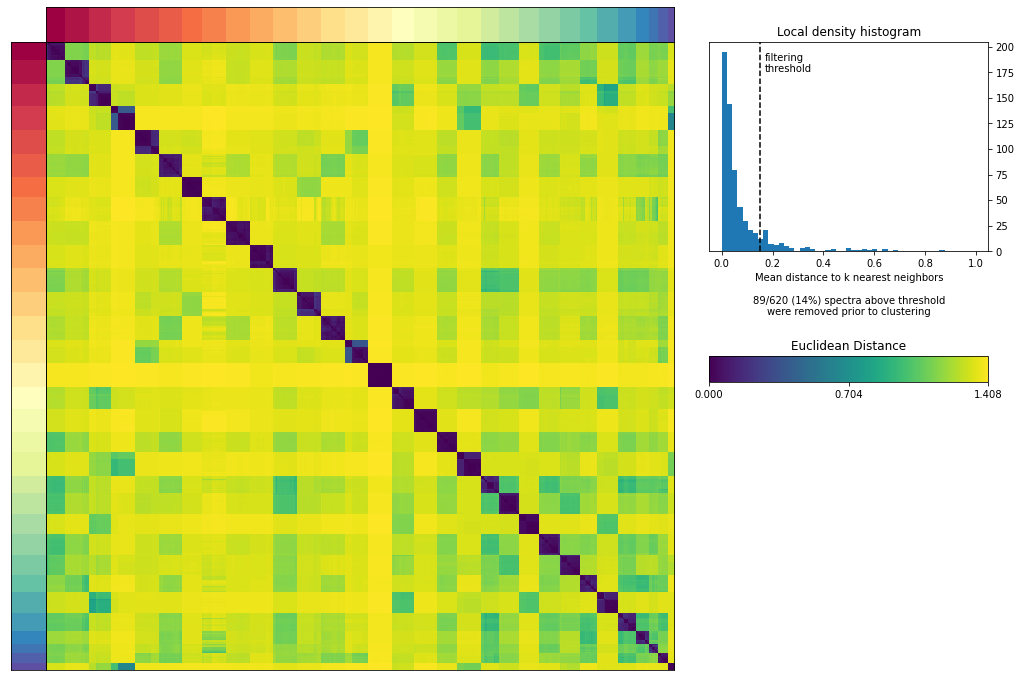

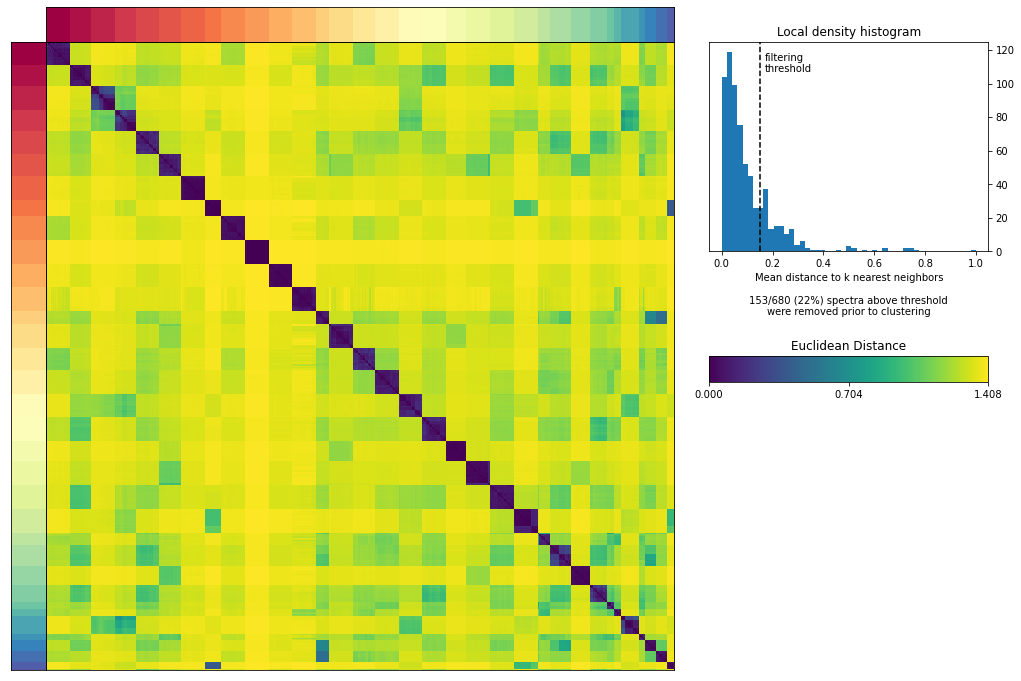

In [19]:
for k in [29, 30, 31, 34]:
    cnmf_obj.consensus(k=k, density_threshold=kthresh[k])

Only considering the two last: ['.norm_counts', '.h5ad'].
Only considering the two last: ['.norm_counts', '.h5ad'].
Only considering the two last: ['.tpm', '.h5ad'].
Only considering the two last: ['.tpm', '.h5ad'].


/PHShome/dk718/miniforge3/envs/cnmf_env2v2/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


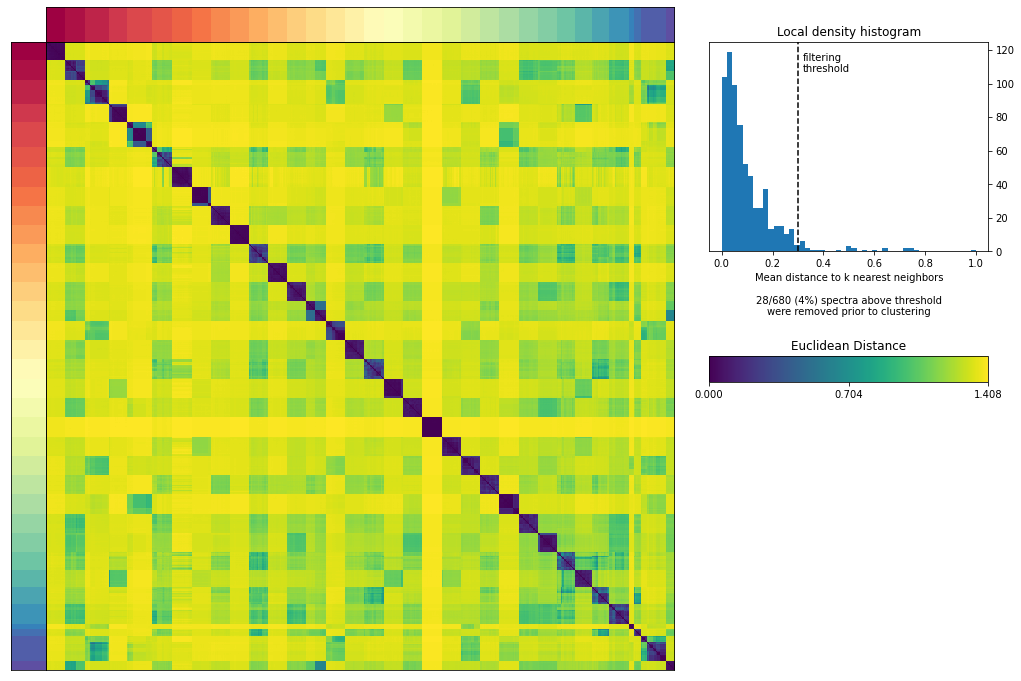

In [23]:
for k in [34]:
    cnmf_obj.consensus(k=k, density_threshold=kthresh[k])

In [24]:
k=31
(usage, spectra_scores, spectra_tpm, top_genes) = cnmf_obj.load_results(K=k, density_threshold=kthresh[k])

In [27]:
top_genes.head(20).iloc[:,:15]

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,TMSB4X,PFDN5,LINC01781,IL4R,PARP14,KCNG1,LINC01857,KLK1,ZNF331,MT-ATP6,HOMER3,COCH,NEIL1,KLF6,S100A9
1,CD72,FAU,RPS14,YBX3,UTRN,AKAP6,TCF4,PPP1R14A,PDE4B,MT-CO2,ITGB1,FGD6,CD9,JUN,LYZ
2,CHI3L2,S100A6,RPS12,PLPP5,MACF1,STAG3,GPM6A,CD1C,RBM38,MT-CO3,MIAT,RNGTT,SOX4,TSC22D3,S100A8
3,VPREB3,RPS4Y1,RPS3,BCL7A,BDP1,SESN1,ZNF804A,CIB1,JUNB,MT-CYB,AB_CD95,BTNL9,HRK,JUND,G0S2
4,FCER2,RPL30,AB_CD45RB,MEF2C,GOLGA4,CNTNAP2,AB_CD1c,AB_CD1c,EZR,MT-ND4,HIPK2,LYPLAL1,AB_CD9,RHOB,VCAN
5,ACTB,TMSB10,RPL27A,FCRL1,TTN,CCR7,FCRL2,SOX5,CD83,MT-ND3,AB_CD99,SHISA8,MME,PPP1R15A,S100A12
6,RPL28,SERF2,RASSF6,PCDH9,HNRNPU,AB_CD73,AB_CD25,CPEB4,LY9,MT-ND2,BAIAP3,NTNG1,BMP3,KLF2,CXCL8
7,TCL1A,SH3BGRL3,AIM2,SKAP1,DDX17,ZBTB16,GNG11,CCDC50,GRASP,MT-ND1,AK8,FGF9,AEBP1,CD69,IL1B
8,SMIM14,EEF1D,RPLP1,KLF3,XIST,ADAM28,RHOBTB3,CSGALNACT1,HERPUD1,MT-CO1,S100A10,SCIMP,AB_CD81,DUSP1,FCN1
9,RPS19,RPS27A,RPLP2,SELL,GOLGB1,UGT2B17,AB_CD45RB,CRIP1,RGS2,MT-ND5,FUT7,HOPX,CCDC191,YWHAH,CCL3


In [28]:
top_genes.head(20).iloc[:,15:]

,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31
0,MPP6,GZMK,ACTG1,CFD,MANF,ISG15,GNLY,AB_CD38-2,EGR1,BIK,PPBP,TYMS,IGHD,UBE2C,CDC20,HBB
1,ITGAX,IL7R,DHRS9,AIF1,SDF2L1,IFIT3,NKG7,AB_CD38-1,DUSP2,AQP3,SPARC,RRM2,IGLL5,ASPM,CEP55,HBA2
2,FCRL5,CD3E,ACTB,FCGR3A,SEC11C,MX1,PRF1,XBP1,IER2,HRASLS2,NRGN,MCM10,IGLV2-8,TOP2A,CDC25A,HBA1
3,AB_CD172a,CD3G,AB_CD71,CDKN1C,HSPA5,IFIT1,GZMB,MZB1,NR4A1,PRDM1,CAVIN2,GINS2,SSR4,KIF23,CCNB2,AB_CD235ab
4,SLC12A8,CD3D,GAPDH,IFITM3,CALR,IFI44L,FGFBP2,CD38,FOSB,ABCB9,PF4,PCLAF,IGLV3-9,MKI67,CCNB1,ALAS2
5,ENC1,AB_CD2,DNAH8,FCER1G,HYOU1,IFI6,KLRD1,IGKC,EGR3,IGKC,CLU,PKMYT1,IGLC2,GTSE1,TROAP,IFI27
6,RBPMS2,IL32,TMSB4X,LST1,CRELD2,XAF1,GZMA,FNDC3B,FOS,BMP8B,LCN2,CDT1,JSRP1,CENPA,DLGAP5,SNCA
7,HSPB1,AB_CD3-2,ZBTB32,SERPINA1,SEC61G,EIF2AK2,SPON2,SLAMF7,ZFP36,IGHA2,TREML1,TK1,FKBP2,CENPF,PLK1,PDZK1IP1
8,AB_CD11c,CD2,ACY3,TCF7L2,SSR3,HERC5,KLRF1,IGHG1,NFKBIA,GLDC,RGS18,CLSPN,DERL3,KIFC1,CENPF,GMPR
9,SYT1,LEF1,CDCA7,MEG3,PDIA6,EPSTI1,CTSW,ITM2C,BTG2,SUB1,ITGA2B,CDC6,ATF5,PLK1,PTTG1,HEMGN


## Compare with original TCATs

In [46]:
metagepinfo = read_dataset_log(tabname='cGEP Paths').loc[0,:]
gepname = read_dataset_log(tabname='cGEP_Name')
rename_map = dict(zip(gepname['cGep_Name'], gepname['Short_Name']))
tcat_spectra_all = pd.read_csv(metagepinfo.loc['scores_spectra'], sep='\t', index_col=0).T
tcat_spectra_all = tcat_spectra_all.rename(columns=rename_map)

In [52]:
k=31
(usage, spectra_scores, spectra_tpm, top_genes) = cnmf_obj.load_results(K=k, density_threshold=kthresh[k])
overlap_genes = list(set(spectra_scores.index).intersection(tcat_spectra_all.index))
mapping, unmatched, R = match_columns(tcat_spectra_all.loc[overlap_genes, :], spectra_scores.loc[overlap_genes, :])
mapping

,Y_columns,X_columns,R
1565,31,Doublet-RBC,0.892107
1043,21,ISG,0.832251
1456,29,CellCycle-G2M,0.829571
235,5,MALAT1,0.826818
1359,27,CellCycle-S,0.721117
1309,26,Doublet-Platelet,0.688907
746,15,Doublet-Myeloid,0.667516
96,2,TXNIP/H1FX,0.579925
472,10,Mito,0.560375
439,9,IEG2,0.554616


In [53]:
(mapping['R']>.55).value_counts()

False    21
True     10
Name: R, dtype: int64

In [50]:
k=34
(usage, spectra_scores, spectra_tpm, top_genes) = cnmf_obj.load_results(K=k, density_threshold=kthresh[k])
overlap_genes = list(set(spectra_scores.index).intersection(tcat_spectra_all.index))
mapping, unmatched, R = match_columns(tcat_spectra_all.loc[overlap_genes, :], spectra_scores.loc[overlap_genes, :])
(mapping['R']>.55).value_counts()

False    24
True     10
Name: R, dtype: int64

In [51]:
k=29
(usage, spectra_scores, spectra_tpm, top_genes) = cnmf_obj.load_results(K=k, density_threshold=kthresh[k])
overlap_genes = list(set(spectra_scores.index).intersection(tcat_spectra_all.index))
mapping, unmatched, R = match_columns(tcat_spectra_all.loc[overlap_genes, :], spectra_scores.loc[overlap_genes, :])
(mapping['R']>.55).value_counts()

False    20
True      9
Name: R, dtype: int64

# K=31

In [54]:
cnmfdir = '../../../Data/PerDataset/HaoEtAl'
name = 'HIVVaccine.Bcell.Iter200'

In [55]:
cnmf_count_fn = paths['RNA_Varnorm_Harmony']
cnmf_tpm_fn = paths['RNA_and_ADT_TP10K']
hvg_fn = paths['RNA_HVG_List']

jname = name
cnmfout = os.path.join(cnmfdir, name, 'log')

Ks = np.arange(31, 32)
n_iter = 200
num_per_node = 4

In [56]:
total_workers = int((len(Ks)*n_iter) / num_per_node)
total_workers

50

In [57]:
cnmf_obj = cNMF(output_dir=cnmfdir, name=name)

In [58]:
cnmf_obj.prepare(counts_fn=cnmf_count_fn, components=Ks,
                 n_iter=n_iter, tpm_fn=cnmf_tpm_fn, genes_file=hvg_fn, init='random')

Only considering the two last: ['.HarmonyGeneCorrect', '.h5ad'].
Only considering the two last: ['.HarmonyGeneCorrect', '.h5ad'].
Only considering the two last: ['.tpm', '.h5ad'].
Only considering the two last: ['.tpm', '.h5ad'].


/PHShome/dk718/miniforge3/envs/cnmf_env2v2/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Only considering the two last: ['.norm_counts', '.h5ad'].
Only considering the two last: ['.norm_counts', '.h5ad'].


In [59]:
if not os.path.exists(cnmfout): os.mkdir(cnmfout)

basecmd = "export OMP_NUM_THREADS=6; cnmf factorize --name {name} --output-dir {outdir} --total-workers {tw} --worker-index {i}"
q = 'short'
other = '-R "rusage[mem=2000]" -R "select[hname!=cn001]" -R "select[hname!=cn002]" -R "select[hname!=cn003]" -R "select[hname!=cn004]" -R "select[hname!=cn005]" -R "select[hname!=cn007]"'

for i in range(total_workers):
    cmd = basecmd.format(name=name, outdir=cnmfdir, i=i, tw=total_workers)
    e = os.path.join(cnmfout, '{j}.{i}.err.txt').format(i=i, j=jname)
    o = os.path.join(cnmfout, '{j}.{i}.out.txt').format(i=i, j=jname)
    bsub_cmd = 'bsub -q {q} -J {j} -o {o} -e {e} {other} "{cmd}"'.format(q=q, j=jname, e=e, o=o, other=other, cmd=cmd)
    print(bsub_cmd)
    !{bsub_cmd}

bsub -q short -J HIVVaccine.Bcell.Iter200 -o ../../../Data/PerDataset/HaoEtAl/HIVVaccine.Bcell.Iter200/log/HIVVaccine.Bcell.Iter200.0.out.txt -e ../../../Data/PerDataset/HaoEtAl/HIVVaccine.Bcell.Iter200/log/HIVVaccine.Bcell.Iter200.0.err.txt -R "rusage[mem=2000]" -R "select[hname!=cn001]" -R "select[hname!=cn002]" -R "select[hname!=cn003]" -R "select[hname!=cn004]" -R "select[hname!=cn005]" -R "select[hname!=cn007]" "export OMP_NUM_THREADS=6; cnmf factorize --name HIVVaccine.Bcell.Iter200 --output-dir ../../../Data/PerDataset/HaoEtAl --total-workers 50 --worker-index 0"
Job <107728> is submitted to queue <short>.
bsub -q short -J HIVVaccine.Bcell.Iter200 -o ../../../Data/PerDataset/HaoEtAl/HIVVaccine.Bcell.Iter200/log/HIVVaccine.Bcell.Iter200.1.out.txt -e ../../../Data/PerDataset/HaoEtAl/HIVVaccine.Bcell.Iter200/log/HIVVaccine.Bcell.Iter200.1.err.txt -R "rusage[mem=2000]" -R "select[hname!=cn001]" -R "select[hname!=cn002]" -R "select[hname!=cn003]" -R "select[hname!=cn004]" -R "select[

In [63]:
! bjobs

No unfinished job found


In [64]:
! bjobs | wc -l

No unfinished job found
0


In [65]:
total_workers = int((len(Ks)*n_iter))
total_workers

200

In [66]:
import os
def worker_filter(iterable, worker_index, total_workers):
    return (p for i,p in enumerate(iterable) if (i-worker_index)%total_workers==0)

def load_df_from_npz(filename):
    with np.load(filename, allow_pickle=True) as f:
        obj = pd.DataFrame(**f)
    return obj

missing = []
run_params = load_df_from_npz(cnmf_obj.paths['nmf_replicate_parameters'])
for worker_i in range(total_workers):
    jobs_for_this_worker = worker_filter(range(len(run_params)), worker_i, total_workers)
    for idx in jobs_for_this_worker:
        p = run_params.iloc[idx, :]
        outfn = cnmf_obj.paths['iter_spectra'] % (p['n_components'], p['iter'])
        if not os.path.exists(outfn):
            #print(worker_i, outfn)
            missing.append(worker_i)
            
len(missing)

0

In [67]:
missing

[]

In [68]:
total_workers = int((len(Ks)*n_iter))
total_workers

200

## Look at the results for K=31 with 200 iterations

In [69]:
cnmf_obj.combine(skip_missing_files=True)

Combining factorizations for k=31.


Only considering the two last: ['.norm_counts', '.h5ad'].
Only considering the two last: ['.norm_counts', '.h5ad'].
Only considering the two last: ['.tpm', '.h5ad'].
Only considering the two last: ['.tpm', '.h5ad'].


/PHShome/dk718/miniforge3/envs/cnmf_env2v2/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


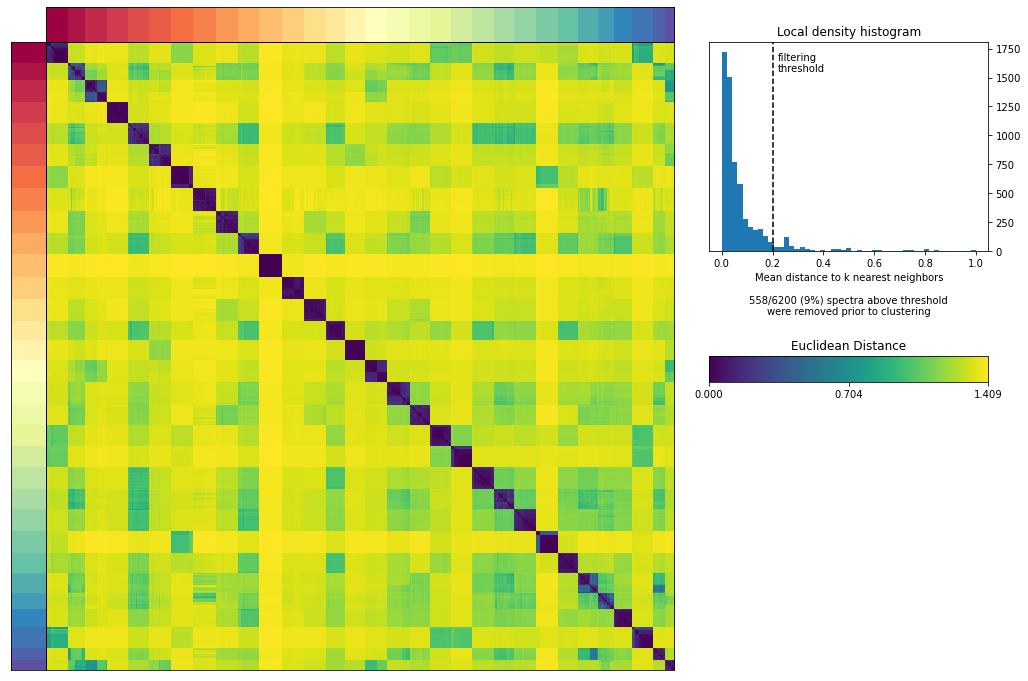

In [71]:
cnmf_obj.consensus(k=31, density_threshold=0.2)

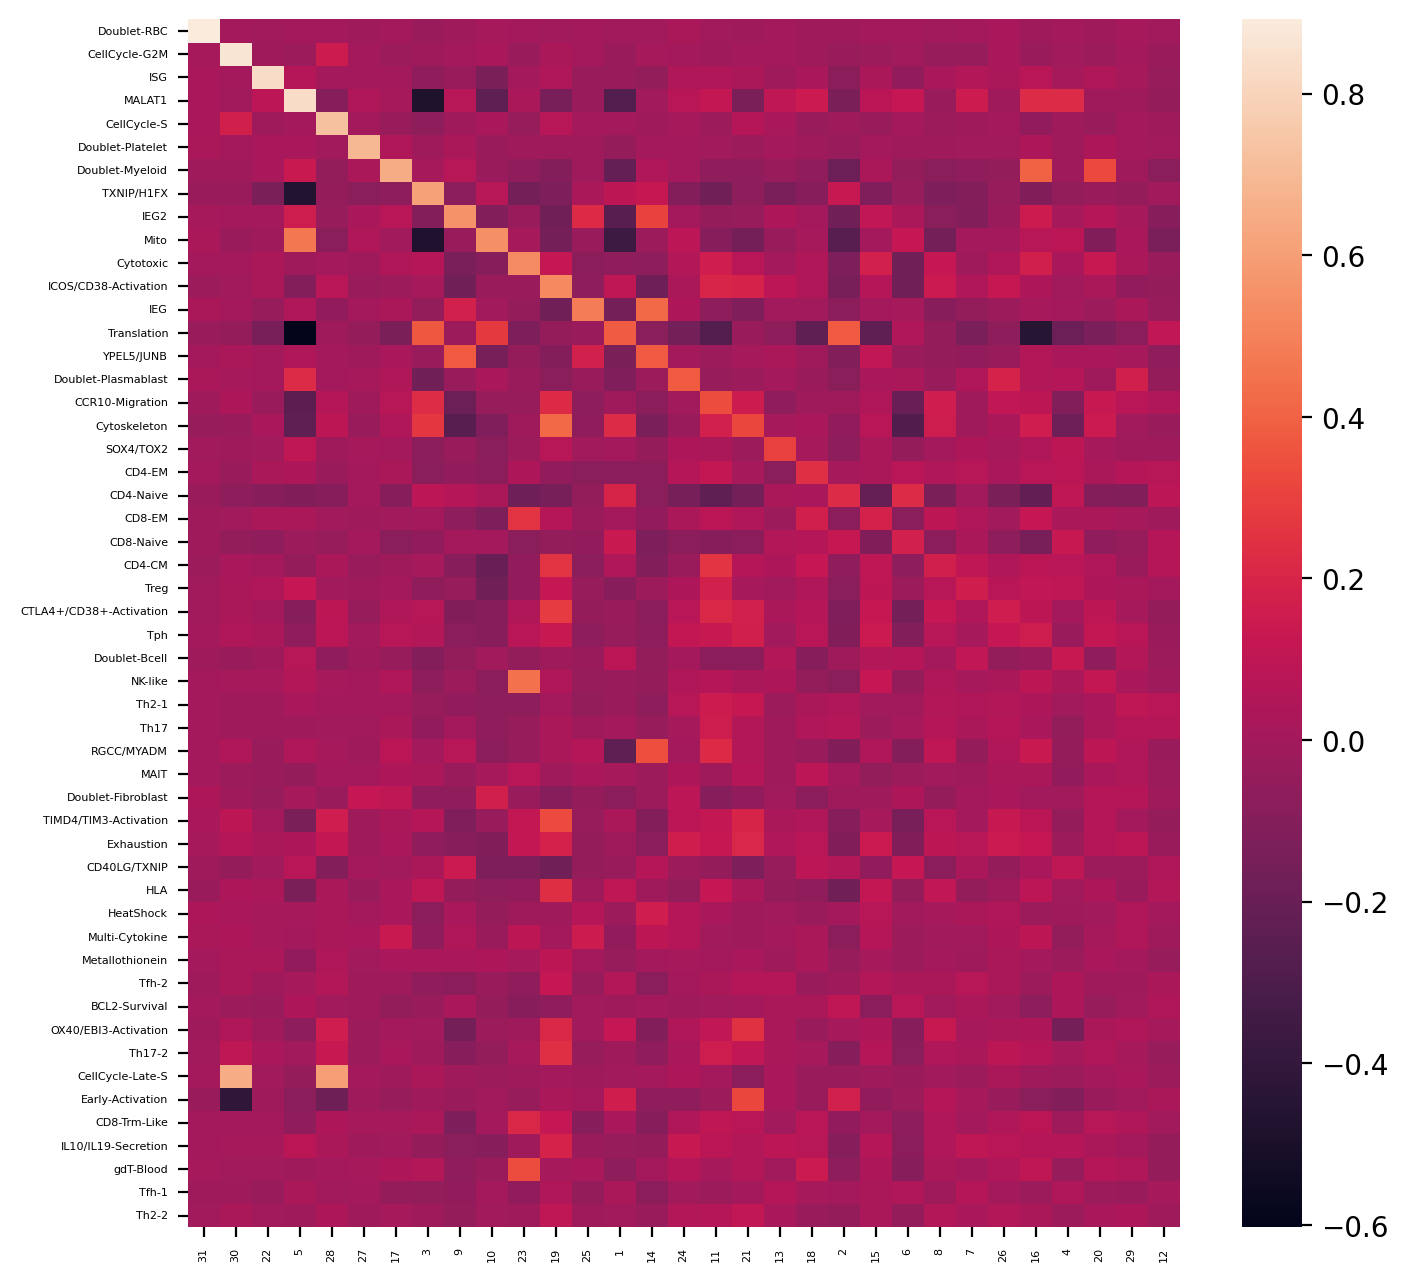

In [72]:
(usage, spectra_scores, spectra_tpm, top_genes) = cnmf_obj.load_results(K=31, density_threshold=0.2)
overlap_genes = list(set(spectra_scores.index).intersection(tcat_spectra_all.index))
mapping, unmatched, R = match_columns(tcat_spectra_all.loc[overlap_genes, :], spectra_scores.loc[overlap_genes, :])
R_for_plot = R.loc[list(mapping['X_columns']) + unmatched, mapping['Y_columns']]
rename_dict = dict(zip(mapping['Y_columns'], mapping['X_columns']))

fig,ax = plt.subplots(1,1, figsize=(8,8), dpi=200)
sns.heatmap(R_for_plot, ax=ax)
ax.set_xticks(np.arange(R_for_plot.shape[1])+0.5)
ax.set_yticks(np.arange(R_for_plot.shape[0])+0.5)
ax.set_xticklabels(R_for_plot.columns, fontsize=4)
_ = ax.set_yticklabels(R_for_plot.index, fontsize=4)